In [15]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [16]:
def plot_history(history):
    # Get the training and validation accuracy and loss from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
images = np.load('data/clock75/images.npy')
labels = np.load('data/clock75/labels.npy')

# images150 = np.load('data/clock150/images.npy')
# labels150 = np.load('data/clock150/labels.npy')

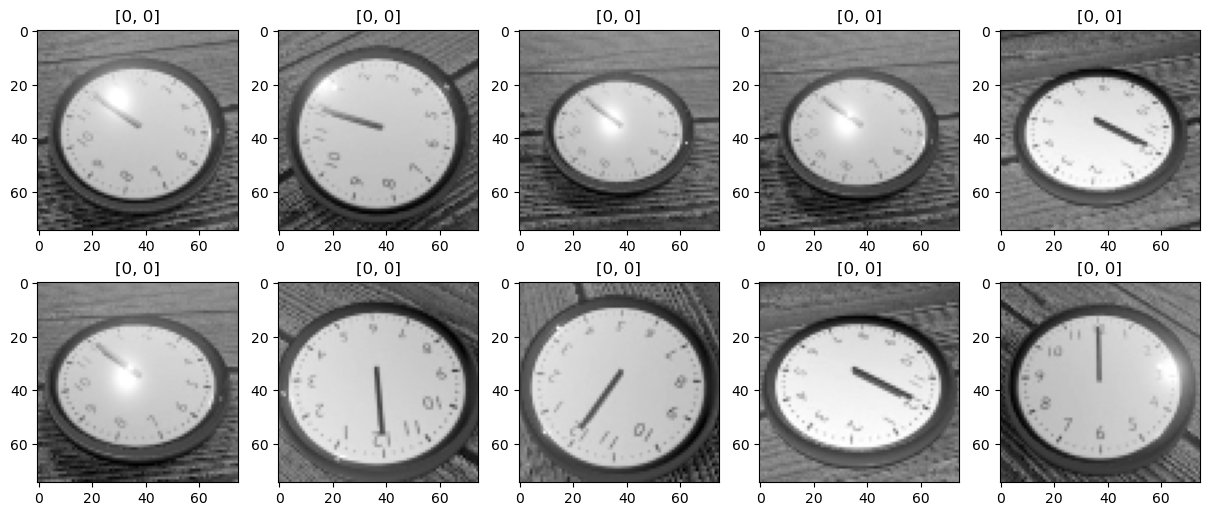

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].imshow(images[i], cmap='gray')
    axs[i // 5, i % 5].set_title(list(labels[i]))
plt.show()

In [19]:
def class_to_num(labels):
    return labels[:, 0]+ labels[:, 1]/60

def num_to_class(numbers):
    hours = np.floor(numbers)
    minutes = (numbers - hours) * 60
    return np.stack([hours, minutes], axis=1)

def class_to_int(labels):
    return labels[:, 0]*60 + labels[:, 1]

#convert labels for regression
labels_num = class_to_num(labels)

#convert labels for classification
labels_int = class_to_int(labels)

In [20]:
#shuffle data
np.random.seed(42)
idx = np.random.permutation(len(images))
images = images[idx]
labels = labels[idx]
labels_num = labels_num[idx]
labels_int = labels_int[idx]

#split data
split = int(0.8 * len(images))
x_train, x_test = images[:split], images[split:]
y_train_og, y_test_og = labels[:split], labels[split:]
y_train_int, y_test_int = labels_int[:split], labels_int[split:]
y_train_num, y_test_num = labels_num[:split], labels_num[split:]

In [22]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

img_rows, img_cols = images.shape[1], images.shape[2]
batch_size = 128
num_classes = 720//5
epochs=100

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

if num_classes == 144:
    y_train_int = y_train_int // 5
    y_test_int = y_test_int // 5

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_int, num_classes)
y_test = keras.utils.to_categorical(y_test_int, num_classes)
print('y_train shape:', y_train.shape)

x_train shape: (14400, 75, 75, 1)
14400 train samples
3600 test samples
y_train shape: (14400, 144)


In [23]:
#create model
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(10, 10), 
#                  activation='relu', 
#                  input_shape=input_shape))
# model.add(Conv2D(64, (10, 10), activation='relu'))
# model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss='poisson',
#                 optimizer='adam',
#                 metrics=['accuracy'])

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 bias_regularizer=keras.regularizers.l2(0.001),
                 activity_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 bias_regularizer=keras.regularizers.l2(0.001),
                 activity_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 bias_regularizer=keras.regularizers.l2(0.001),
                 activity_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',
#                  kernel_regularizer=keras.regularizers.l2(0.001),
#                  bias_regularizer=keras.regularizers.l2(0.001),
#                  activity_regularizer=keras.regularizers.l2(0.001)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())

# model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 73, 73, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 73, 73, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 34, 34, 64)       256       
 hNormalization)                                                 
                                                      

In [24]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.125)

score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/100


2024-11-01 14:53:34.871296: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 283500000 exceeds 10% of free system memory.
2024-11-01 14:53:35.011221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 283500000 exceeds 10% of free system memory.


 1/99 [..............................] - ETA: 1:04 - loss: 27.3549 - accuracy: 0.0312

2024-11-01 14:53:35.672709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-01 14:53:35.789343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-01 14:53:35.789394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-01 14:53:35.790865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-01 14:53:35.790903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

99/99 [==============================] - 4s 32ms/step - loss: 6.1170 - accuracy: 0.0055 - val_loss: 5.1025 - val_accuracy: 0.0050
Epoch 2/100


2024-11-01 14:53:38.828432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-01 14:53:38.873087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-01 14:53:38.873151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-01 14:53:38.876828: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-01 14:53:38.876868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

99/99 [==============================] - 3s 31ms/step - loss: 5.1005 - accuracy: 0.0063 - val_loss: 5.0900 - val_accuracy: 0.0050
Epoch 3/100
99/99 [==============================] - 4s 38ms/step - loss: 5.0823 - accuracy: 0.0063 - val_loss: 5.0797 - val_accuracy: 0.0044
Epoch 4/100
99/99 [==============================] - 3s 30ms/step - loss: 5.0694 - accuracy: 0.0090 - val_loss: 5.0720 - val_accuracy: 0.0044
Epoch 5/100
99/99 [==============================] - 3s 30ms/step - loss: 5.0179 - accuracy: 0.0101 - val_loss: 5.0812 - val_accuracy: 0.0056
Epoch 6/100
99/99 [==============================] - 3s 30ms/step - loss: 4.9082 - accuracy: 0.0124 - val_loss: 5.2638 - val_accuracy: 0.0072
Epoch 7/100
99/99 [==============================] - 3s 30ms/step - loss: 4.8087 - accuracy: 0.0141 - val_loss: 5.2149 - val_accuracy: 0.0111
Epoch 8/100
99/99 [==============================] - 3s 30ms/step - loss: 4.6583 - accuracy: 0.0177 - val_loss: 4.7501 - val_accuracy: 0.0200
Epoch 9/100
99/99 

In [11]:
print(score)

[4.7359113693237305, 0.13972222805023193]


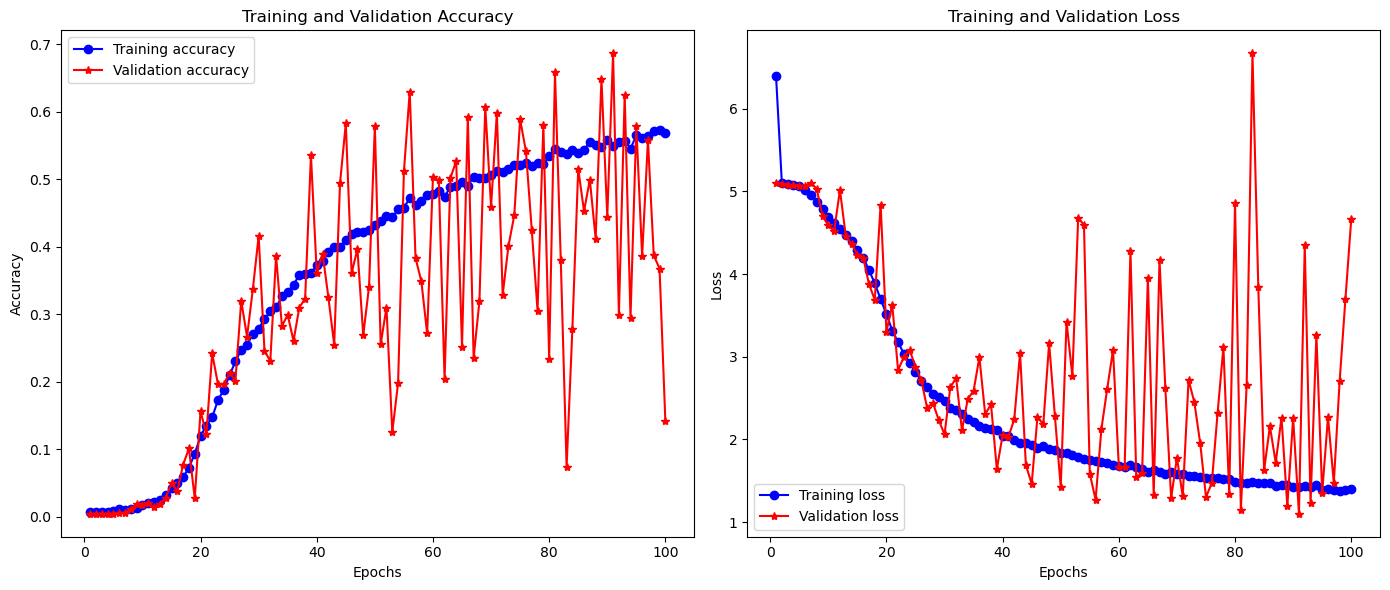

In [12]:
plot_history(history)

 62/113 [===============>..............] - ETA: 0s

2024-11-01 14:43:35.820328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 0s 3ms/step


2024-11-01 14:43:36.130800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-01 14:43:36.130854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-01 14:43:36.165741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-01 14:43:36.165803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: 

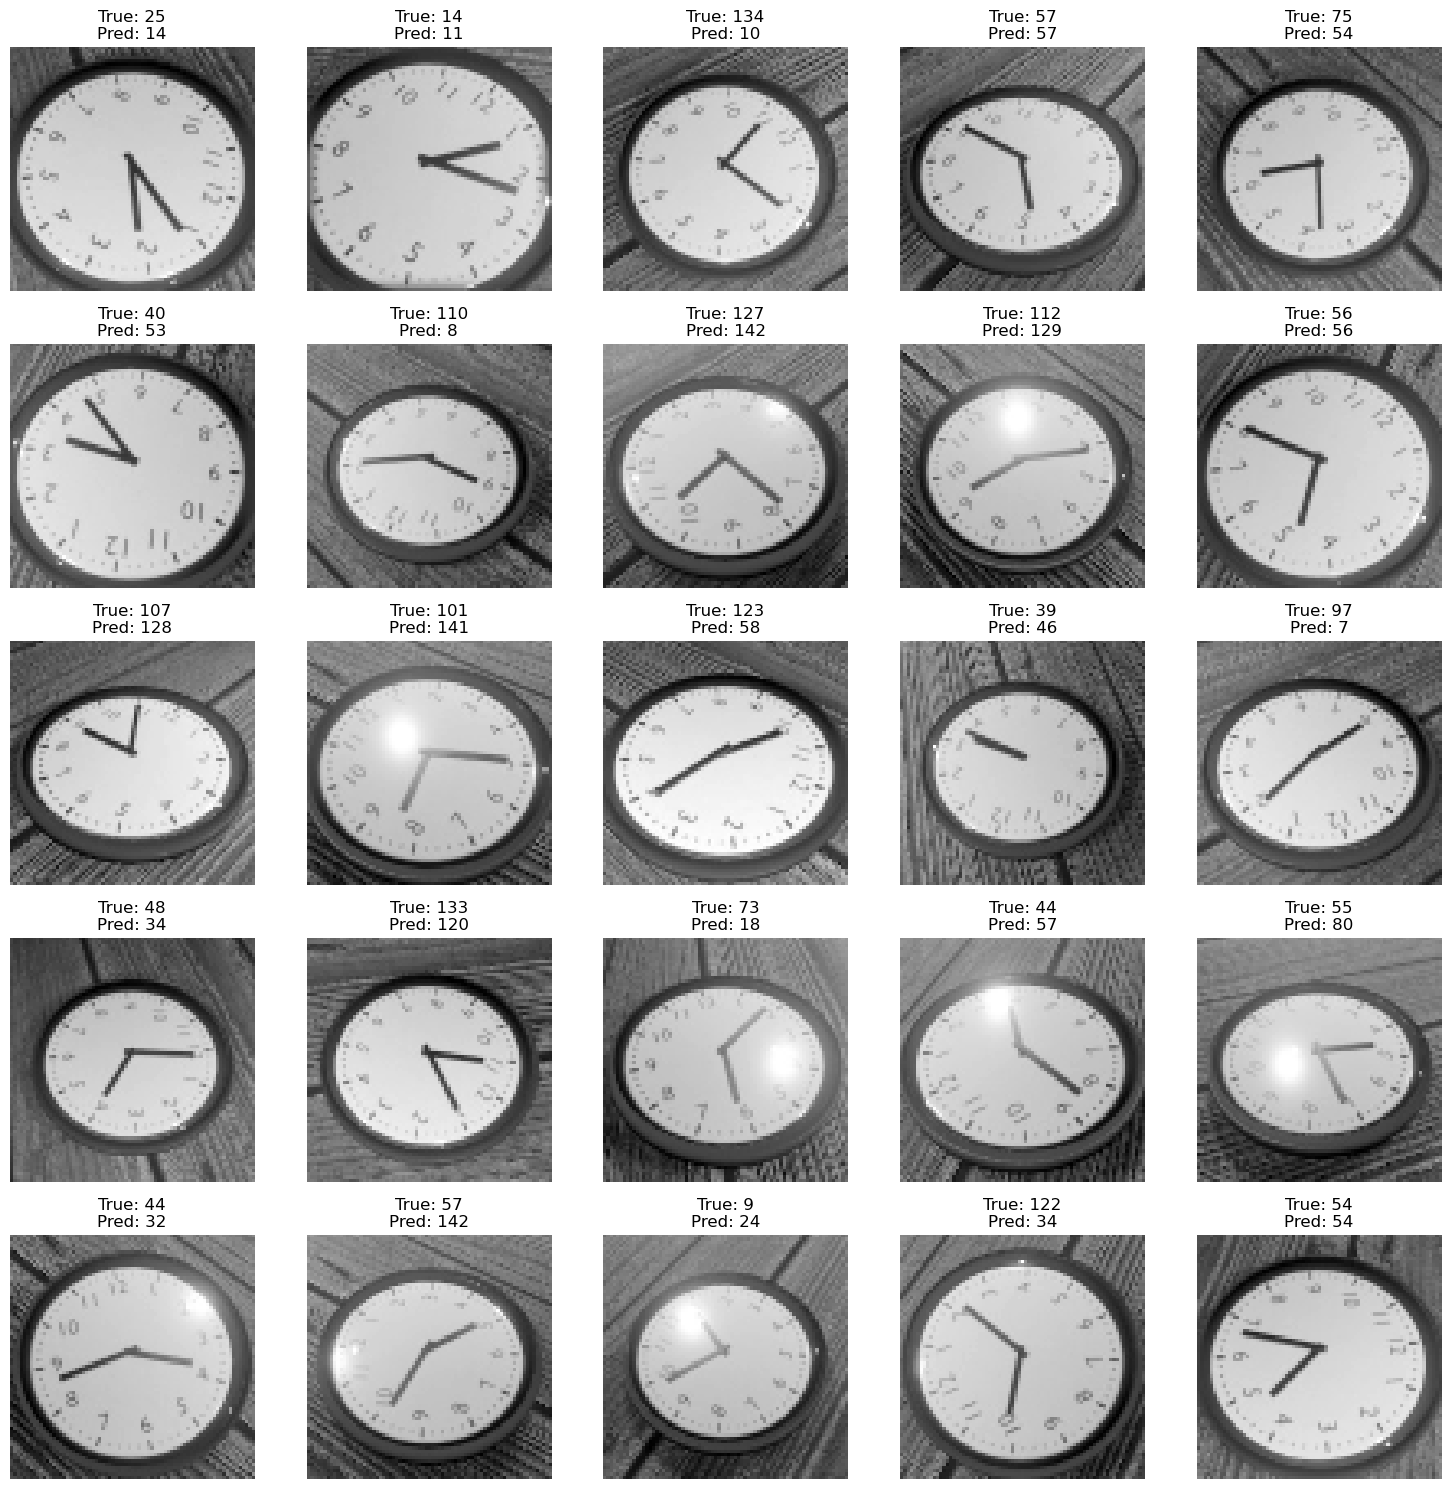

In [13]:
# Predict the classes for the test set
predictions = model.predict(x_test)

# Convert predictions from one-hot encoding to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Function to plot images and their predicted & true labels
def plot_images(images, true_labels, predicted_labels, num_images):
    # Define max images per row
    max_images_per_row = 5
    # Calculate the number of rows needed
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row

    # Create a figure with subplots
    plt.figure(figsize=(15, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, max_images_per_row, i + 1)  # num_rows rows, max_images_per_row columns
        plt.imshow(images[i].reshape(img_rows, img_cols), cmap='gray')
        plt.title(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the specified number of images from the test set
plot_images(x_test, true_classes, predicted_classes, num_images=25)

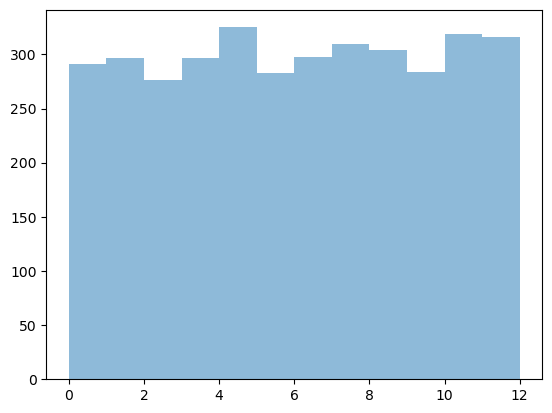

(array([291., 297., 276., 297., 325., 283., 298., 310., 304., 284., 319.,
        316.]),
 array([  0.        ,  11.91666667,  23.83333333,  35.75      ,
         47.66666667,  59.58333333,  71.5       ,  83.41666667,
         95.33333333, 107.25      , 119.16666667, 131.08333333,
        143.        ]),
 <BarContainer object of 12 artists>)

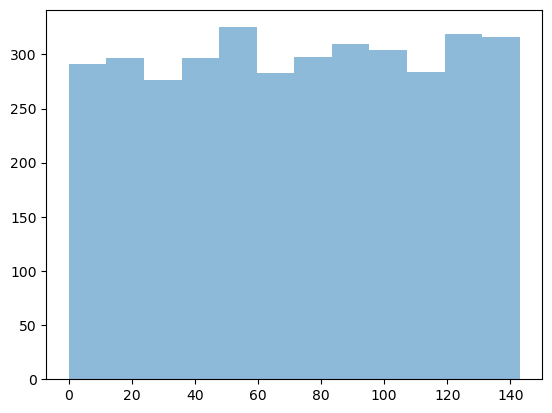

In [14]:
plt.hist(y_test_og[:, 0], bins=range(0, 13), alpha=0.5, label='True')
plt.show()

plt.hist(y_test_int, bins=12, alpha=0.5, label='True')